In [4]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import Lars
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')


def get_orthogonal_vec(vec):
    """Get one (of potentially many) orthogonal vectors to input"""
    dim = len(vec)
    basis_idx = np.argmin(np.abs(np.identity(dim) @ vec))
    basis_vec = np.zeros(dim)
    basis_vec[basis_idx] += 1
    return basis_vec - (basis_vec @ vec) * vec


def generate_data(dim, corpus_size, num_sv, seed):
    """Generate a dataset with a single test point on one 
    side of a half space, the remaining points on the other side
    or the hyperplane itself. Then the nearest point on the convex
    hull of the non-test set examples is located at [1,1, ... , 1]
    
    Args:
        dim (int): number of dimensions.
        corpus_size (int): number of datapoints in corpus.
        num_sv (1 or 2): number of support vectors.
        seed (int): random seed
    """
    bias = np.array(dim*[1])
    np.random.seed(seed)
    H = np.random.normal(size=dim)
    H /= np.sum(H**2)**0.5

    if num_sv == 1:
        data = [np.array(dim*[0]) + bias]
    else:
        # note that H is orthogonal to the hyperplane
        data = [get_orthogonal_vec(H) + bias, - get_orthogonal_vec(H) + bias]

    while True:
        new_point = np.random.normal(size=dim)
        if H @ new_point < 0:
            data.append(new_point + bias)
        if len(data) == corpus_size:
            break
    test_point = H + bias 
    print(H)
    
    return np.vstack(data), test_point

def fit_simplex_np(corpus, test_point, n_keep):
    corpus_t = torch.tensor(corpus, dtype=torch.float32)
    test_point_t = torch.tensor(test_point, dtype=torch.float32).unsqueeze(0)
    simplex = Simplex(corpus_t)
    simplex.fit(test_point_t, n_epoch = 20000, n_keep=n_keep)
    approx = simplex.weights @ simplex.corpus_latent_reps
    approx_np = approx.numpy()
    weights_np = simplex.weights.numpy()
    return approx_np[0], weights_np[0]




In [136]:
# alternative approach

class SimplexCombo:
    def __init__(self, corpus_latent_reps: torch.Tensor) -> None:
        """
        Initialize a SimplEx explainer
        :param corpus_examples: corpus input features
        :param corpus_latent_reps: corpus latent representations
        """
        self.corpus_latent_reps = corpus_latent_reps
        self.corpus_size = corpus_latent_reps.shape[0]
        self.dim_latent = corpus_latent_reps.shape[-1]
        self.weights = None
        self.n_test = None
        self.hist = None
        self.test_examples = None
        self.test_latent_reps = None
        self.jacobian_projections = None

    def fit(self, test_latent_reps: torch.Tensor,
            n_epoch: int = 10000, reg_factor: float = 1.0, n_keep: int = 5, reg_factor_scheduler=None, dist_factor=1) -> None:
        """
        Fit the SimplEx explainer on test examples
        :param test_examples: test example input features
        :param test_latent_reps: test example latent representations
        :param n_keep: number of neighbours used to build a latent decomposition
        :param n_epoch: number of epochs to fit the SimplEx
        :param reg_factor: regularization prefactor in the objective to control the number of allowed corpus members
        :param n_keep: number of corpus members allowed in the decomposition
        :param reg_factor_scheduler: scheduler for the variation of the regularization prefactor during optimization
        :return:
        """
        n_test = test_latent_reps.shape[0]
        preweights1 = torch.zeros((n_test, self.corpus_size), device=test_latent_reps.device, requires_grad=True)
        preweights2 = torch.zeros((n_test, self.corpus_size), device=test_latent_reps.device, requires_grad=True)
        alpha =  torch.ones(n_test, device=test_latent_reps.device)/2
        alpha.requires_grad = True
        optimizer = torch.optim.Adam([preweights1, preweights2, alpha])
        hist = np.zeros((0, 2))
        for epoch in range(n_epoch):
            optimizer.zero_grad()
            weights1 = F.softmax(preweights1, dim=-1) # baseline
            weights2 = F.softmax(preweights2, dim=-1) # \hat{h}
            corpus_latent_reps1 = torch.einsum('ij,jk->ik', weights1, self.corpus_latent_reps)
            corpus_latent_reps2 = torch.einsum('ij,jk->ik', weights2, self.corpus_latent_reps)
            preds = corpus_latent_reps1 + alpha @ (corpus_latent_reps2 - corpus_latent_reps1)
            error = ((preds - test_latent_reps) ** 2).sum()
            dist_loss = ((corpus_latent_reps2 - test_latent_reps) ** 2).sum()
            weights_sorted1 = torch.sort(weights1)[0]
            regulator1 = (weights_sorted1[:, : (self.corpus_size - 1)]).sum()
            weights_sorted2 = torch.sort(weights2)[0]
            regulator2 = (weights_sorted2[:, : (self.corpus_size - n_keep)]).sum()
            loss = error + dist_factor * dist_loss + reg_factor * (regulator1 + regulator2)
            loss.backward()
            optimizer.step()
            if reg_factor_scheduler:
                reg_factor = reg_factor_scheduler.step(reg_factor)
            hist = np.concatenate((hist,
                                   np.array([loss.item(), regulator1.item()]).reshape(1, 2)),
                                  axis=0)
        self.weights1 = torch.softmax(preweights1, dim=-1).detach()
        self.weights2 = torch.softmax(preweights2, dim=-1).detach()
        self.alpha = alpha.detach()
        self.test_latent_reps = test_latent_reps
        self.n_test = n_test
        self.hist = hist

In [168]:
def fit_simplex_np(corpus, test_point, n_keep):
    corpus_t = torch.tensor(corpus, dtype=torch.float32)
    test_point_t = torch.tensor(test_point, dtype=torch.float32).unsqueeze(0)
    simplex = SimplexCombo(corpus_t)
    simplex.fit(test_point_t, n_epoch = 20000, n_keep=n_keep, reg_factor=0.1/2, dist_factor=0.1/2)
    return simplex

def euclid_dist(a, b):
    return ((a - b)**2).sum()**0.5


[0.88094818 0.47321275]


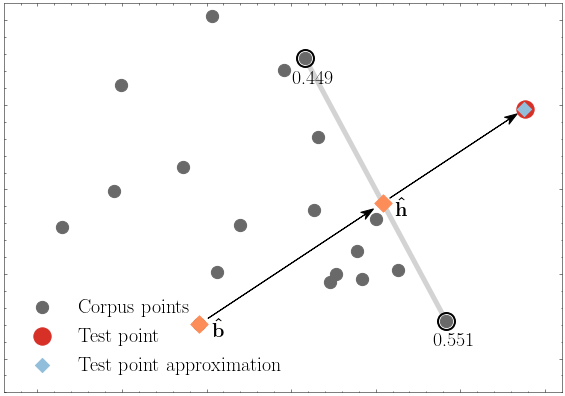

In [240]:
# using the same data as the previous plots, apply the proposed approach

n_keep = 2
point_size = 150
line_width = 5
text_size = 20
delta = -0.15
seed=10

corpus, test_point = generate_data(dim=2, corpus_size=20, num_sv=2, seed=seed)
corpus = np.vstack([corpus[:6], corpus[7:]])  # remove an extreme point for aesthetics

simplex = fit_simplex_np(corpus, test_point, n_keep=n_keep)
b = (simplex.weights1 @ simplex.corpus_latent_reps).numpy()
h = (simplex.weights2 @ simplex.corpus_latent_reps).numpy()
final = b[0] + simplex.alpha.numpy() @ (h - b)


plt.figure(figsize=(10,10))
ax = plt.gca()

ax.set_aspect('equal',adjustable='box')
plt.plot(corpus[:2,0], corpus[:2,1], c='lightgrey', zorder=-1, linewidth=line_width)

ax.scatter(corpus[:,0], corpus[:,1], c='dimgrey', s=point_size, label='Corpus points')
plt.scatter(test_point[0], test_point[1], c='#d73027', s=point_size+150, label='Test point')
plt.scatter(h[0][0],h[0][1], c='#fc8d59', s=point_size, marker="D") # h
ax.annotate(r'$\mathbf{\hat{h}}$', ((h[0][0] -0.5*delta, h[0][1]+ 0.5 * delta)), fontsize=text_size)

plt.scatter(b[0][0],b[0][1], c='#fc8d59', s=point_size, marker="D") # b
ax.annotate(r'$\mathbf{\hat{b}}$', ((b[0][0] -0.5*delta, b[0][1]+ 0.5 * delta)), fontsize=text_size)

plt.scatter(final[0],final[1], c='#91bfdb', s=point_size-50, marker="D", label='Test point approximation')

arrow_start = b[0] + 0.05*(h[0]-b[0])
arrow_end = 0.9*(h[0]-b[0])
plt.arrow(arrow_start[0],arrow_start[1],arrow_end[0] , arrow_end[1], head_width=0.05, length_includes_head=True,
         color="k", overhang=0.3)

arrow_start = h[0] + 0.05*(final-h[0])
arrow_end = 0.9*(final-h[0])
plt.arrow(arrow_start[0],arrow_start[1],arrow_end[0] , arrow_end[1], head_width=0.05, length_includes_head=True,
         color="k", overhang=0.3)

plt.legend(loc= 'lower left', prop={'size': 20})
ax.tick_params(labelbottom=False, labelleft=False) 
plt.ylim(-0.2,2.1)
plt.xlim(-1.2, 2.1)
weights = simplex.weights2.numpy()[0]
for i, w in enumerate(weights):
    if w > 0.05:
        w = round(w,3)
        ax.plot(corpus[i:i+1,0], corpus[i:i+1,1], 'o', ms=17, mec='black', mfc='none', mew=2)
        ax.annotate(w, (corpus[i,0] + 0.5*delta, corpus[i,1] + delta), fontsize=text_size)
# plt.savefig(f'sample_baseline.pdf', format='pdf', dpi=1200)
plt.show()